# DSE 10 Homework 4 - Due 02/05/2021 9:00am

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mvn

#modules for worksheet 10
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from pylab import rcParams # for display 

# Worksheet 9 Problem 3

#### all the data for problem 3 will be saved in ``cwd/20news-bydate/matlab``, ``cwd`` is current working directory, except for "vocabulary.txt" will be saved in ``cwd``.

## Problem 3 (a)

In [2]:
!curl http://qwone.com/~jason/20Newsgroups/20news-bydate.tar.gz -o 20news-bydate.tar.gz
    
!tar -xf 20news-bydate.tar.gz && rm 20news-bydate.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13.7M  100 13.7M    0     0  3510k      0  0:00:04  0:00:04 --:--:-- 3510k


In [3]:
!ls

20news-bydate-test              predicate-matrix.png
20news-bydate-train             predicates.txt
Features                        t10k-images-idx3-ubyte
README-attributes.txt           t10k-labels-idx1-ubyte
classes.txt                     testclasses.txt
hu_yuan.ipynb                   train-images-idx3-ubyte
lampert-cvpr2009.pdf            train-labels-idx1-ubyte
predicate-matrix-binary.txt     trainclasses.txt
predicate-matrix-continuous.txt


In [4]:
#!rm -r 20news-bydate-train && rm -r 20news-bydate-test

## Problem 3 (b)

#### (b) The same website has a processed version of the data, “[20news-bydate-matlab.tgz](http://qwone.com/~jason/20Newsgroups/20news-bydate-matlab.tgz)”, that is particularly convenient to use. Download this and also the file “[vocabulary.txt](http://qwone.com/~jason/20Newsgroups/vocabulary.txt)”. Look at the first training document in the processed set and the corresponding original text document to understand the relation between the two.

In [5]:
#download 20news-bydate
!curl http://qwone.com/~jason/20Newsgroups/20news-bydate-matlab.tgz -o data
#download vocabulary.txt
!curl http://qwone.com/~jason/20Newsgroups/vocabulary.txt -o vocabulary.txt

#unzip and delete zip file
!tar -xf data  && rm data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7398k  100 7398k    0     0  2595k      0  0:00:02  0:00:02 --:--:-- 2594k  0:00:03  0:00:02  0:00:01 2326k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  482k  100  482k    0     0   749k      0 --:--:-- --:--:-- --:--:--  749k


In [6]:
!ls

20news-bydate                   predicate-matrix.png
20news-bydate-test              predicates.txt
20news-bydate-train             t10k-images-idx3-ubyte
Features                        t10k-labels-idx1-ubyte
README-attributes.txt           testclasses.txt
classes.txt                     train-images-idx3-ubyte
hu_yuan.ipynb                   train-labels-idx1-ubyte
lampert-cvpr2009.pdf            trainclasses.txt
predicate-matrix-binary.txt     vocabulary.txt
predicate-matrix-continuous.txt


In [7]:
def data_processing(data_path, label_path):
    #process labels
    labels = pd.read_csv(label_path, header = None)
    labels = labels.rename(columns={0: "Class"})
    labels.index = labels.index + 1
    labels.index.names = ['docIdx']
    
    #process data
    data = pd.read_csv(data_path, delimiter = " ", header = None)
    data.rename(columns={0: "docIdx", 1: "wordIdx", 2: "Count"}, inplace=True) 
    
    return data, labels

def count_V(filepath):
    f = open(filepath, 'r')
    words = f.readlines()
    return len(words)

In [8]:
#load and preprocess training data
train_data = '20news-bydate/matlab/train.data'
train_label = '20news-bydate/matlab/train.label'
data, labels = data_processing(train_data, train_label)

#merge data with labels
data = data.merge(labels, how='left', on='docIdx')

#load and preprocess testing data
test_data = '20news-bydate/matlab/test.data'
test_labels = '20news-bydate/matlab/test.label'
test, test_labels = data_processing(test_data, test_labels)

#number of words
V_path = 'vocabulary.txt'
n_words = count_V(V_path)

print(f"Problem 3(b):")
print("===============================================================")
print("train.data(first 10 rows in transposed display):")
print(data.head(10).T)
print("\n")
print("label.data:")
print(labels.Class.values)
print("---------------------------------------------------------------")
print("""The raw matlab train.data was organized by 3 columns: 
    1st column(dodIdx)   --->  the index of documents
    2nd column(wordIdx)  --->  the index of words
    3rd column(Count)    --->  the count of occurrence of words
         
The raw matlab train.label stores labels for each documents""")

Problem 3(b):
train.data(first 10 rows in transposed display):
         0  1   2  3  4  5  6  7  8   9
docIdx   1  1   1  1  1  1  1  1  1   1
wordIdx  1  2   3  4  5  6  7  8  9  10
Count    4  2  10  4  2  1  1  1  3   9
Class    1  1   1  1  1  1  1  1  1   1


label.data:
[ 1  1  1 ... 20 20 20]
---------------------------------------------------------------
The raw matlab train.data was organized by 3 columns: 
    1st column(dodIdx)   --->  the index of documents
    2nd column(wordIdx)  --->  the index of words
    3rd column(Count)    --->  the count of occurrence of words
         
The raw matlab train.label stores labels for each documents


## Problem 3 (c)

#### (c) The words in the documents constitute an overall vocabulary V of size 61188. Build a multinomial Naive Bayes model using the training data. For each of the 20 classes j = 1, 2, . . . , 20, you must have the following:
   

- #### $\pi_j$, the fraction of documents that belong to that class
- #### $P_j$, a probability distribution over V that models the documents of that class

#### In order to fit $P_j$ , imagine that all the documents of class $j$ are strung together. For each word $w \in V$ , let Pjw be the fraction of this concatenated document occupied by $w$. Well, almost: you will need to do smoothing (just add one to the count of how often $w$ occurs).

#### Raw data ---> DataFrames ---> Bag-of-Words Matrix ---> NaiveBayesMultinomial( ) ---> Result

In [9]:
def bag_of_words(df, n_words):
    """
    dataframe: DataFrame("docIdx","wordIdx","Count","Class")
    n_words: the number of unique words in "vocabulary.txt"
    
    word_mat: word count matrix of shape (n_documents, n_words)
              this result also will serve us as X_train
    """
    n_docs = df.docIdx.nunique()

    word_mat = np.zeros((n_docs, n_words))
    for i in range(n_docs):
        doc = df[df.docIdx==i+1]
        word_vec = np.zeros((n_words, ))
        mask = doc.wordIdx.values-1
        word_vec[mask] = doc.Count.values
        word_mat[i]=word_vec
        
    return word_mat

In [10]:
class NaiveBayesMultinomial():
    """Class implement of Naive Bayes Multinomial Classifier"""
    
    
    def __init__(self, alpha=1, tf='f', tfidf=False):
        self.alpha = alpha
        self.tf = tf
        self.tfidf = tfidf
        print(f"Initiating Naive-Bayes-Multinomial-Classifier: alpha={self.alpha}, tf={self.tf}, tfidf={self.tfidf}")
        
        
    def fit(self, X, y):
        self.n_classes = np.unique(y).shape[0]
        self.n_docs = X.shape[0]
        self.n_words = X.shape[1]
        
        #vector(20,), number of documents in each class
        n_docs_class = np.array([y[y==j].shape[0] for j in range(1, self.n_classes+1)]) #class starts from 1
        self.prior = n_docs_class/np.sum(n_docs_class)
        
        self.likelihood = self._multinomials(X, y)
        
        
    def _multinomials(self, X, y):
        tf = np.zeros((self.n_classes, self.n_words))

        for j in range(20):
            jth_class = X[y==j+1]
            #add-one smoothing
            f = (np.sum(jth_class, axis=0) + self.alpha)/(np.sum(jth_class) + self.alpha*n_words)
            if self.tf == 'f':
                tf[j] = f
            else:
                tf[j] = np.log(1+f)
        return tf
    

    # calculate optimal solution for MAP estimator
    def predict(self, X):
        if X.ndim == 1:
            n_test_samples = 1
        else:
            n_test_samples = X.shape[0]

        labels = np.zeros((n_test_samples, ))
        for i in range(n_test_samples):
            log_prob = np.sum(np.log(self.likelihood)*X[i], axis=1) + np.log(self.prior)
            labels[i] = np.argmax(log_prob)+1
        return labels
    
    
    def accuracy(self, X, y):
        acc = X[X==y].shape[0]/y.shape[0]
        print(f"Predicting on {y.shape[0]} samples, Accuracy:{round(acc, 3)}")
        return acc
    
    
    def clf_instance(self):
        return self.prior, self.likelihood

In [11]:
X_train = bag_of_words(data, n_words)
y_train = labels.Class.values

In [12]:
#model for 3c
clf_3c = NaiveBayesMultinomial()
clf_3c.fit(X_train, y_train)
prior, likelihood = clf_3c.clf_instance()
print("\n")
print(f"Problem 3(c):")
print("===================================================================")
print(f"Prior probabilities: Array of shape ({prior.shape[0]}, )")
print(f"Constraint: sum of prior probabilities equals to {np.sum(prior)}")
print("\n")
print(f"{prior}")
print("\n")
print(f"Likelihood probabilities: Matrix of shape ({likelihood.shape[0]}, {likelihood.shape[1]})")
print(f"Constraint: sum of likelihood probabilities of each class equals to {np.sum(likelihood, axis=1)}")
print("\n")
print(likelihood)
print("\n")

Initiating Naive-Bayes-Multinomial-Classifier: alpha=1, tf=f, tfidf=False


Problem 3(c):
Prior probabilities: Array of shape (20, )
Constraint: sum of prior probabilities equals to 1.0


[0.04259473 0.05155737 0.05075872 0.0520898  0.05102494 0.0525335
 0.05164611 0.0525335  0.05288846 0.05271098 0.05306593 0.05271098
 0.05244476 0.05271098 0.05262224 0.05315467 0.04836277 0.05004881
 0.0411749  0.03336587]


Likelihood probabilities: Matrix of shape (20, 61188)
Constraint: sum of likelihood probabilities of each class equals to [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


[[6.66666667e-05 3.04761905e-04 1.31428571e-03 ... 4.76190476e-06
  4.76190476e-06 4.76190476e-06]
 [3.55589754e-04 3.49760414e-04 5.82934024e-06 ... 5.82934024e-06
  5.82934024e-06 5.82934024e-06]
 [7.89707479e-05 4.60662696e-04 6.58089566e-06 ... 6.58089566e-06
  6.58089566e-06 6.58089566e-06]
 ...
 [3.48108977e-05 4.90517195e-04 3.16462706e-06 ... 3.16462706e-06
  3.16462706e-06 3.16462706e-06]

## Problem 3 (d)

#### (d) Write a routine that uses this naive Bayes model to classify a new document. To avoid underflow, work with logs rather than multiplying together probabilities.

In [13]:
print("""Problem 3(d):
===================================================================
Classifying Routines:

    1. data:         load train data to DataFrame 'data' (see problem 3(b))
       labels:       load train labels to DataFrame 'labels' (see problem 3(b))
       test:         load test data to DataFrame 'test' (see problem 3(b))
       test_labels:  load test labels to DataFrame 'test_labels' (see problem 3(b))
           
    2. X_train:      calculate term-frequency Matrix for X_train from DataFrame 'data'
       y_train:      get labels information from DataFrame for y_train from DataFrame 'labels'
       X_test:       calculate term-frequency Matrix for X_test from DataFrame 'test'
       y_test:       get labels information from DataFrame for y_test from 'test_labels'
           
    3. define:       clf = NaiveBayesMultinomial() 
       fit:          clf.fit(X_train, y_train)
       predict:      X_pred = clf.predict(X_test)
       accuracy:     Accuracy = clf.accuracy(X_pred, y_test) 
              """)

Problem 3(d):
Classifying Routines:

    1. data:         load train data to DataFrame 'data' (see problem 3(b))
       labels:       load train labels to DataFrame 'labels' (see problem 3(b))
       test:         load test data to DataFrame 'test' (see problem 3(b))
       test_labels:  load test labels to DataFrame 'test_labels' (see problem 3(b))
           
    2. X_train:      calculate term-frequency Matrix for X_train from DataFrame 'data'
       y_train:      get labels information from DataFrame for y_train from DataFrame 'labels'
       X_test:       calculate term-frequency Matrix for X_test from DataFrame 'test'
       y_test:       get labels information from DataFrame for y_test from 'test_labels'
           
    3. define:       clf = NaiveBayesMultinomial() 
       fit:          clf.fit(X_train, y_train)
       predict:      X_pred = clf.predict(X_test)
       accuracy:     Accuracy = clf.accuracy(X_pred, y_test) 
              


In [14]:
print("""
    In the fitting process, based on the input training data, a words-counts matrix will be generalized 
    first, I use term-frequency to name it however it actually stores the counts, then this matrix will 
    be used to calculate multinomial probabilities for every single words within each class, this is actually 
    the true term-frequency matrix, also this step will apply add-one smoothing. The last step is to find the 
    largest MAP estimator by calculating:
""")


    In the fitting process, based on the input training data, a words-counts matrix will be generalized 
    first, I use term-frequency to name it however it actually stores the counts, then this matrix will 
    be used to calculate multinomial probabilities for every single words within each class, this is actually 
    the true term-frequency matrix, also this step will apply add-one smoothing. The last step is to find the 
    largest MAP estimator by calculating:



$$\underset{j}{\operatorname{argmax}} log(\pi_j)+\sum^{|V|}_{i}X_i* log P_j(X_i)$$

## Problem 3 (e)

#### (e) Evaluate the performance of your model on the test data. What error rate do you achieve?

In [15]:
X_test = bag_of_words(test, n_words)
y_test = test_labels.Class.values

In [16]:
print("""Problem 3(d):
===================================================================""")
print("\n")
clf = NaiveBayesMultinomial()
clf.fit(X_train, y_train)
X_pred = clf.predict(X_test)
print("\n")
print("PREDICTING ... ...")
print("\n")
clf.accuracy(X_pred, y_test)

Problem 3(d):


Initiating Naive-Bayes-Multinomial-Classifier: alpha=1, tf=f, tfidf=False


PREDICTING ... ...


Predicting on 7505 samples, Accuracy:0.781


0.7810792804796802

<br/><br/>

## Problem 3 (f)

#### Method 1: Apply log(1+f) and test on validation set

In [17]:
from sklearn.model_selection import train_test_split
X_train_, X_valid, y_train_, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [18]:
clf_1 = NaiveBayesMultinomial(tf="log")
clf_1.fit(X_train_, y_train_)
X_pred_1 = clf_1.predict(X_valid)
acc_1 = clf_1.accuracy(X_pred_1, y_valid)

Initiating Naive-Bayes-Multinomial-Classifier: alpha=1, tf=log, tfidf=False
Predicting on 2254 samples, Accuracy:0.84


### Accuracy on validation set increased dramatically, which was expected.

#### Method 2: Apply tf-idf and test on validation set

$$idf(t, D) = log \frac{N}{1+ |\{d\in D: t\in d\}|}$$

N: total number of documents in the corpus $N=|D|$

$|\{d\in D: t\in d\}|$: number of documents where the term t appears. If the term is not in the corpus, this will lead to a division by zero. Therefore it is common to adjust the denominator to $1+|\{d\in D: t\in d\}|$

$$Tfidf = tf(t, D)*idf(t, D)$$

In [19]:
#calculate tf matrix
def multinomials(X_train, y_train):
    n_classes = np.unique(y_train).shape[0]
    tf = np.zeros((n_classes, n_words))
    #X_train = X_train + 1
    for j in range(20):
        jth_class = X_train[y_train==j+1]
        f = (np.sum(jth_class, axis=0)+1)/(np.sum(jth_class) + n_words)
        tf[j] = f
    return tf


#calculate idf matrix
def inverse_term_frequency(X, y, n_words):
    n_classes = np.unique(y).shape[0]

    idf = np.zeros((n_classes, n_words))
    for i in range(20):
        D = X[y==i+1]
        N = np.array(D.shape[0])
        df = np.count_nonzero(D, axis=0) + 1 #add 1 for smoothing
        idf[i] = np.log(N/df)
        
    return idf


# revised estimator with tfidf weight
def estimator_tfidf(X_test, prior, tfidf):
    if X_test.ndim == 1:
        n_documents = 1
    else:
        n_documents = X_test.shape[0]

    labels = np.zeros((n_documents, ))
    for i in range(n_documents):
        log_prob = np.sum(np.log(tfidf)*X_test[i], axis=1) + np.log(prior)
        labels[i] = np.argmax(log_prob)+1
    return labels

In [20]:
#number of documents
N = np.array([X_train_[y_train_==i+1].shape[0] for i in range(20)])
N

array([376, 471, 447, 465, 462, 461, 468, 467, 490, 479, 486, 480, 471,
       480, 484, 473, 432, 447, 377, 299])

In [21]:
tf = multinomials(X_train_, y_train_)

In [22]:
idf = inverse_term_frequency(X_train_, y_train_, n_words)

In [23]:
tfidf= tf*idf

In [24]:
X_pred_2 = estimator_tfidf(X_valid, prior, tfidf)

In [25]:
acc_2 = X_pred_2[X_pred_2==y_valid].shape[0]/y_valid.shape[0]
print(f"Predicting on {y_valid.shape[0]} samples, Accuracy:{round(acc_2, 3)}")

Predicting on 2254 samples, Accuracy:0.761


### Not doing great as we expected.

In [26]:
print(f"""Problem 3(d):
===================================================================
Applied log(1+f) on validation set, validate accuracy {acc_1}

Applied TF-IDF on validation set, validate accuracy {acc_2}

Need put in more work on consolidate final model and testing.""")

Problem 3(d):
Applied log(1+f) on validation set, validate accuracy 0.8398402839396628

Applied TF-IDF on validation set, validate accuracy 0.7613132209405501

Need put in more work on consolidate final model and testing.


<br/><br/>

# Worksheet 9 Problem 4

## Problem 4 (a) Load data

In [27]:
# helper functions
from struct import unpack
import numpy as np
import matplotlib.pylab as plt 

#load from 
def loadmnist(imagefile, labelfile):
    # Open the images with gzip in read binary mode
    images = open(imagefile, 'rb')
    labels = open(labelfile, 'rb')

    # Get metadata for images
    images.read(4)  # skip the magic_number
    number_of_images = images.read(4)
    number_of_images = unpack('>I', number_of_images)[0]
    rows = images.read(4)
    rows = unpack('>I', rows)[0]
    cols = images.read(4)
    cols = unpack('>I', cols)[0]

    # Get metadata for labels
    labels.read(4)
    N = labels.read(4)
    N = unpack('>I', N)[0]

    # Get data
    x = np.zeros((N, rows*cols), dtype=np.uint8)  # Initialize numpy array
    y = np.zeros(N, dtype=np.uint8)  # Initialize numpy array
    for i in range(N):
        for j in range(rows*cols):
            tmp_pixel = images.read(1)  # Just a single byte
            tmp_pixel = unpack('>B', tmp_pixel)[0]
            x[i][j] = tmp_pixel
        tmp_label = labels.read(1)
        y[i] = unpack('>B', tmp_label)[0]

    images.close()
    labels.close()
    return (x, y)

#display a single data point
def displaychar(image):
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.axis('off')
    plt.show()

In [28]:
#load unzipped file
X, y = loadmnist('train-images-idx3-ubyte', 'train-labels-idx1-ubyte')

Problem 4(a):
Dimension of X: (60000, 784)
Dimension of labels y: (60000,)


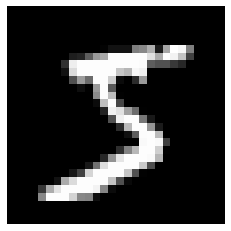

Each single data entry represents an image of 28 x 28 pixels, each pixel represnets a greyscale ranging from 0 to 255.



In [29]:
print(f"""Problem 4(a):
===================================================================
Dimension of X: {X.shape}
Dimension of labels y: {y.shape}""")

displaychar(X[0])
print(f"""Each single data entry represents an image of 28 x 28 pixels, each pixel represnets a greyscale ranging from 0 to 255.
""")


## Problem 4 (b) Split training data and load test data

In [30]:
def train_valid_split(X,y):
    train_index = np.random.choice(range(X.shape[0]), size=(50000,), replace=False)
    valid_index = np.array([i for i in range(X.shape[0]) if i not in train_index])
    
    X_train = X[train_index]
    X_valid = X[valid_index]
    y_train = y[train_index]
    y_valid = y[valid_index]
    
    return X_train, X_valid, y_train, y_valid

In [31]:
X_train, X_valid, y_train, y_valid = train_valid_split(X,y)

In [32]:
#load testing file
X_test, y_test = loadmnist('t10k-images-idx3-ubyte', 't10k-labels-idx1-ubyte')
print(f"Dimension of X_test:{X_test.shape}")
print(f"Dimension of y_test:{y_test.shape}")

Dimension of X_test:(10000, 784)
Dimension of y_test:(10000,)


In [33]:
print(f"""Problem 4(b):
===================================================================
After splitting training data:""")
print(f"Dimension of X_train after splitting:{X_train.shape}")
print(f"Dimension of y_train after splitting:{y_train.shape}")
print(f"Dimension of X_valid after splitting:{X_valid.shape}")
print(f"Dimension of y_valid after splitting:{y_valid.shape}")

Problem 4(b):
After splitting training data:
Dimension of X_train after splitting:(50000, 784)
Dimension of y_train after splitting:(50000,)
Dimension of X_valid after splitting:(10000, 784)
Dimension of y_valid after splitting:(10000,)


## Problem 4 (c) Fit a Gaussian model and predict

In [34]:
class Gaussian_clf():
    
    def __init__(self, var_smoothing=1e-2):
        self.var_smoothing = var_smoothing

       
    def _prior_prob(self, y):
        self.n_classes = np.unique(y).shape[0]
        return np.array([y[y==i].shape[0]/y.shape[0] for i in range(self.n_classes)])
    
    
    def fit(self, X, y):
        """
        X: array-like of shape (n_samples, n_features)
           n_samples is the number of samples
           and n_features is the number of features.
        y: array-like of shape (n_classes,)
           n_classes is the number of classes
        """
        self.priors = self._prior_prob(y)
        self.n_features = X.shape[1]
        
        self.mu = np.array([X[np.where(y==i)].mean(axis=0) for i in range(self.n_classes)])
        
        sigma = np.array([np.cov(X[np.where(y==i)].T) for i in range(self.n_classes)])
        self.sigma = sigma + np.eye(self.n_features)*self.var_smoothing #smoothing covariance matrix
        
        return self.priors, self.mu, self.sigma
    
    
    def predict_proba(self, X):
        """
        X: array-like of shape (n_samples, n_features)
           
        probas: array-like of shape (n_samples, )
                maximum probabilty of samples among different classes
        """
        if X.ndim == 1:
            self.n_samples = 1
        else:
            self.n_samples = X.shape[0]
        
        #pass in the whole trainning data into mvn.logpdf()
        log_likelihood = np.array([mvn.logpdf(X, mean=self.mu[j],cov=self.sigma[j]) for j in range(self.n_classes)]) 
        # summation of log(p_j) and p_j(X) by broadcasting
        probas = np.log(self.priors) + log_likelihood.T
        
        return probas
    
        #using loops
        #probs = np.zeros((self.n_classes, self.n_samples))
        #for i in range(10):
            #probs[i] = np.log(pi[i]) + mvn.logpdf(X, mean=self.mu[i], cov=self.sigma[i])
        #return probs
    
        
    def predict(self, X):
        """
        X: array-like of shape (n_samples, n_features)
           
        res: array-like of shape (n_samples, )
            class labels for each sample
        """
        probs = self.predict_proba(X)
        
        return np.argmax(probs, axis=1)

In [35]:
clf_4 = Gaussian_clf()
priors, mu, sigma = clf_4.fit(X_train, y_train)
log_likelihood = clf_4.predict_proba(X_valid)

In [36]:
print(f"""Problem 4(c):
===================================================================
Prior Probabilities:
{priors}
---------------------------------------------------------
Mean Vector:
{mu}
---------------------------------------------------------
Covariance Matrix(Smoothed with Constant 0.01)
{sigma}
---------------------------------------------------------
Log(Prior*Likelihood) estimated with training data:
{log_likelihood}""")

Problem 4(c):
Prior Probabilities:
[0.09792 0.11202 0.09946 0.10188 0.09784 0.09042 0.0988  0.10518 0.09742
 0.09906]
---------------------------------------------------------
Mean Vector:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
---------------------------------------------------------
Covariance Matrix(Smoothed with Constant 0.01)
[[[0.01 0.   0.   ... 0.   0.   0.  ]
  [0.   0.01 0.   ... 0.   0.   0.  ]
  [0.   0.   0.01 ... 0.   0.   0.  ]
  ...
  [0.   0.   0.   ... 0.01 0.   0.  ]
  [0.   0.   0.   ... 0.   0.01 0.  ]
  [0.   0.   0.   ... 0.   0.   0.01]]

 [[0.01 0.   0.   ... 0.   0.   0.  ]
  [0.   0.01 0.   ... 0.   0.   0.  ]
  [0.   0.   0.01 ... 0.   0.   0.  ]
  ...
  [0.   0.   0.   ... 0.01 0.   0.  ]
  [0.   0.   0.   ... 0.   0.01 0.  ]
  [0.   0.   0.   ... 0.   0.   0.01]]

 [[0.01 0.   0.   ... 0.   0.   0.  ]
  [0.   0.01 0.   ... 0.   0.   0.  ]
  

## Problem 4 (d) Select smooth constant and classify on test data

In [37]:
def cal_err_rate(X, y, var_smoothing):
    err_index = X[X!=y]
    err_rate = err_index.shape[0]/y.shape[0]
   # err_rate = 1-np.mean(X==y)
    print(f"Smoothing constant: {var_smoothing}     Classifier ERROR RATE: {round(err_rate*100, 2)}%")
    return err_rate

def choose_smooth_var(X_train, y_train, X_test, y_test, var_smoothing_selections):
    print(f"RUNNING SMOOTHING CONSTANT SLECTION FROM {var_smoothing_selections}")
    print(f"----------------------------------------------------------------------")
    
    err = {}
    for c in var_smoothing_selections:
        clf = Gaussian_clf(var_smoothing=c) #define classifier from our implementation
        clf.fit(X_train, y_train)
        X_pred = clf.predict(X_test)
        err[c] = cal_err_rate(X_pred, y_test, c)

    min_err = min(err.values());  
    best_c = [key for key, value in err.items() if value == min_err]
    
    print(f"----------------------------------------------------------------------")
    print(f"The best smoothing constant among {len(var_smoothing_selections)} selections is {best_c[0]}")
    
    return err

Problem 4(d):
RUNNING SMOOTHING CONSTANT SLECTION FROM [10000.0, 1000.0, 100.0, 10.0, 1.0, 0.1, 0.01, 0.001]
----------------------------------------------------------------------
Smoothing constant: 10000.0     Classifier ERROR RATE: 5.71%
Smoothing constant: 1000.0     Classifier ERROR RATE: 5.67%
Smoothing constant: 100.0     Classifier ERROR RATE: 8.94%
Smoothing constant: 10.0     Classifier ERROR RATE: 12.96%
Smoothing constant: 1.0     Classifier ERROR RATE: 16.61%
Smoothing constant: 0.1     Classifier ERROR RATE: 19.48%
Smoothing constant: 0.01     Classifier ERROR RATE: 22.37%
Smoothing constant: 0.001     Classifier ERROR RATE: 24.73%
----------------------------------------------------------------------
The best smoothing constant among 8 selections is 1000.0




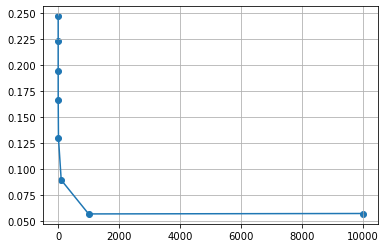



Running Gaussian classifier with smoothing constant 1000 on test data ...
Smoothing constant: 1000     Classifier ERROR RATE: 4.88%




In [38]:
print(f"""Problem 4(d):
======================================================================""")
var_smoothing_selections = [1e4, 1e3, 1e2, 1e1, 1e0, 1e-1, 1e-2, 1e-3]
err_info = choose_smooth_var(X_train, y_train, X_valid, y_valid, var_smoothing_selections)

print("\n")
#display error rate trends with different smoothing constants
plt.scatter([*err_info.keys()], [*err_info.values()])
plt.plot([*err_info.keys()], [*err_info.values()])
plt.grid()
plt.show()

print("\n")
print("Running Gaussian classifier with smoothing constant 1000 on test data ...")
clf_5 = Gaussian_clf(var_smoothing=1000)
priors_, mu_, sigma_ = clf_5.fit(X_train, y_train)
X_pred_5 = clf_5.predict(X_test)

err_rate = cal_err_rate(X_pred_5, y_test, 1000)
print("\n")

## Problem 4 (e) 

In [39]:
def pick_five():
    mis_idx = []
    for idx, v in np.ndenumerate(X_pred_5):
        if v != y_test[idx]:
            mis_idx.append(idx[0])
            
    to_display = np.random.choice(mis_idx, 5)
    return to_display

In [40]:
def display_five(picks):
    
    fig, axs = plt.subplots(1,5,figsize=(15,15))
    fig.suptitle("FIVE RANDOM PICKED MISCLASSIFIED DIGITS FROM TEST SET")
    fig.tight_layout()
    fig.subplots_adjust(top=1.6)
    for i in range(5):
        axs[i].imshow(np.reshape(X_test[to_display[i]], (28,28)), cmap=plt.cm.gray)
        axs[i].set_title(f"digit at index {to_display[i]} --> {int(X_pred[to_display[i]])}")
        axs[i].axis('off')

Problem 4(e):
Note: Since Underflows happened when calculate posterior probabilities, 
      below will display log(Prior*Likelihood) instead.


log(Prior*Likelihood) of mis-classified sample at index 1112 is:
[-3795.30984739 -4443.51799628 -3793.6943423  -3830.93948696
 -3788.8983539  -3871.19081636 -3733.42718484 -3988.08275509
 -3900.26422426 -3921.62743694]
------------------------------------------------------------------
log(Prior*Likelihood) of mis-classified sample at index 111 is:
[-3863.73993826 -3661.32413385 -3767.6002025  -3775.8772335
 -3726.10439819 -3826.12808683 -3950.13435406 -3668.95527172
 -3710.6308751  -3707.10339057]
------------------------------------------------------------------
log(Prior*Likelihood) of mis-classified sample at index 4433 is:
[-4103.32227388 -4245.79533894 -3810.50134923 -3849.60735112
 -3856.64316505 -3930.20805838 -4091.59735741 -3906.87311232
 -3967.65731837 -4108.09837042]
------------------------------------------------------------------

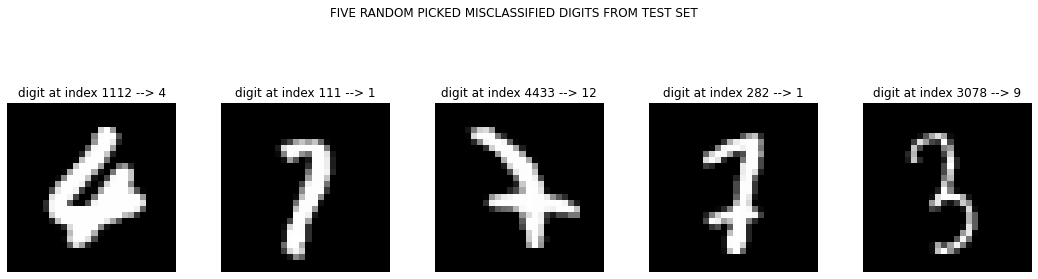

In [42]:
log_likelihood_5 = clf_5.predict_proba(X_test)
to_display = pick_five()

print(f"""Problem 4(e):
================================================================================================""")
display_five(to_display)

print(f"""Note: Since Underflows happened when calculate posterior probabilities, 
      below will display log(Prior*Likelihood) instead.""")
print("\n")
for i in to_display:
    print(f"log(Prior*Likelihood) of mis-classified sample at index {i} is:")
    print(log_likelihood_5[i])
    print("------------------------------------------------------------------")

<br/><br/>

# Worksheet 10 Problem 2

1. For this problem, we’ll be using the animals with attributes data set. Go to
    http://attributes.kyb.tuebingen.mpg.de and, under “Downloads”, choose the “base package” (the very first file in thelist). Unzip it and look over the various text files. 
    
2. This is a small data set that has information about 50 animals. The animals are listed in classes.txt. For each animal, the information consists of values for 85 features: does the animal have a tail, is it slow, does it have tusks, etc. The details of the features are in predicates.txt. The full data consists of a 50 × 85 matrix of real values, in predicate-matrix-continuous.txt. There is also a binarized version of this data, in predicate-matrix-binary.txt.

# Problem 2(a)

#### (a) Load the real-valued array, and also the animal names, into Python. Run k-means on the data (from sklearn.cluster) and ask for k = 10 clusters. For each cluster, list the animals in it. Does the clustering make sense?

In [43]:
names = pd.read_csv("classes.txt", delimiter = "\t", header = None)
names = names.rename(columns={0: "Class", 1:"name"})
names = names.name.values
names

array(['antelope', 'grizzly+bear', 'killer+whale', 'beaver', 'dalmatian',
       'persian+cat', 'horse', 'german+shepherd', 'blue+whale',
       'siamese+cat', 'skunk', 'mole', 'tiger', 'hippopotamus', 'leopard',
       'moose', 'spider+monkey', 'humpback+whale', 'elephant', 'gorilla',
       'ox', 'fox', 'sheep', 'seal', 'chimpanzee', 'hamster', 'squirrel',
       'rhinoceros', 'rabbit', 'bat', 'giraffe', 'wolf', 'chihuahua',
       'rat', 'weasel', 'otter', 'buffalo', 'zebra', 'giant+panda',
       'deer', 'bobcat', 'pig', 'lion', 'mouse', 'polar+bear', 'collie',
       'walrus', 'raccoon', 'cow', 'dolphin'], dtype=object)

In [44]:
features_df = pd.read_csv("predicates.txt", delimiter = "\t", header = None)
features = features_df.iloc[:,-1].values
features

array(['black', 'white', 'blue', 'brown', 'gray', 'orange', 'red',
       'yellow', 'patches', 'spots', 'stripes', 'furry', 'hairless',
       'toughskin', 'big', 'small', 'bulbous', 'lean', 'flippers',
       'hands', 'hooves', 'pads', 'paws', 'longleg', 'longneck', 'tail',
       'chewteeth', 'meatteeth', 'buckteeth', 'strainteeth', 'horns',
       'claws', 'tusks', 'smelly', 'flys', 'hops', 'swims', 'tunnels',
       'walks', 'fast', 'slow', 'strong', 'weak', 'muscle', 'bipedal',
       'quadrapedal', 'active', 'inactive', 'nocturnal', 'hibernate',
       'agility', 'fish', 'meat', 'plankton', 'vegetation', 'insects',
       'forager', 'grazer', 'hunter', 'scavenger', 'skimmer', 'stalker',
       'newworld', 'oldworld', 'arctic', 'coastal', 'desert', 'bush',
       'plains', 'forest', 'fields', 'jungle', 'mountains', 'ocean',
       'ground', 'water', 'tree', 'cave', 'fierce', 'timid', 'smart',
       'group', 'solitary', 'nestspot', 'domestic'], dtype=object)

In [45]:
values_df = pd.read_csv("predicate-matrix-continuous.txt", delim_whitespace=True, header = None)
X = values_df.values
X

array([[-1.  , -1.  , -1.  , ...,  2.35,  9.7 ,  8.38],
       [39.25,  1.39,  0.  , ..., 58.64, 20.14, 11.39],
       [83.4 , 64.79,  0.  , ..., 15.77, 13.41, 15.42],
       ...,
       [63.57, 43.1 ,  0.  , ..., 35.95, 28.26,  5.  ],
       [55.31, 55.46,  0.  , ...,  5.04, 18.89, 72.99],
       [10.22, 21.53, 27.73, ...,  3.96, 14.05, 37.98]])

In [46]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(X)

In [47]:
cluster_index = kmeans.predict(X)

In [48]:
def list_names():
    name_dic = {i: [] for i in range(10)}
    for i, j in enumerate(cluster_index):
        name_dic[j].append(names[i])
     
    #return name_dic
    for key, value in name_dic.items():
        print(f"Cluster {key+1} has animals: {value}")

In [49]:
print(f"Problem 2(a):")
print(f"===================================================================")
list_names()
print(""" 
      The result makes sense to some extent, such as cluster 2 segragated all marine mammals, 
      cluster 8 segragated “big cats”, cluster 9 has bears, etc. However, the 'persian+cat' shouldn't 
      appear in cluster 1, 'siamese+cat' shouldn't appear in cluster 3 and 'bat' shouldn't be grouped 
      with “Apes” in cluster 6.""")

Problem 2(a):
Cluster 1 has animals: ['persian+cat', 'skunk', 'mole', 'hamster', 'squirrel', 'rabbit', 'chihuahua', 'rat', 'weasel', 'mouse', 'raccoon']
Cluster 2 has animals: ['killer+whale', 'blue+whale', 'humpback+whale', 'seal', 'walrus', 'dolphin']
Cluster 3 has animals: ['dalmatian', 'german+shepherd', 'siamese+cat', 'fox', 'wolf', 'collie']
Cluster 4 has animals: ['antelope', 'giraffe', 'deer']
Cluster 5 has animals: ['hippopotamus', 'elephant', 'rhinoceros']
Cluster 6 has animals: ['spider+monkey', 'gorilla', 'chimpanzee', 'bat']
Cluster 7 has animals: ['horse', 'moose', 'ox', 'sheep', 'buffalo', 'zebra', 'giant+panda', 'pig', 'cow']
Cluster 8 has animals: ['tiger', 'leopard', 'bobcat', 'lion']
Cluster 9 has animals: ['grizzly+bear', 'polar+bear']
Cluster 10 has animals: ['beaver', 'otter']
 
      The result makes sense to some extent, such as cluster 2 segragated all marine mammals, 
      cluster 8 segragated “big cats”, cluster 9 has bears, etc. However, the 'persian+cat' s

# Problem 2(b)

#### (b) Now hierarchically cluster this data, using scipy.cluster.hierarchy.linkage. Choose Ward’s method, and plot the resulting tree using the dendrogram method, setting the orientation parameter to ‘right’ and labeling each leaf with the corresponding animal name. You will run into a problem: the plot is too cramped because the default figure size is so small. To make it larger, preface your code with the following:
~~~python
from pylab import rcParams
rcParams[’figure.figsize’] = 5, 10
~~~
#### (or try a different size if this doesn’t seem quite right). Does the hierarchical clustering seem sensible to you?

Problem 2(b):


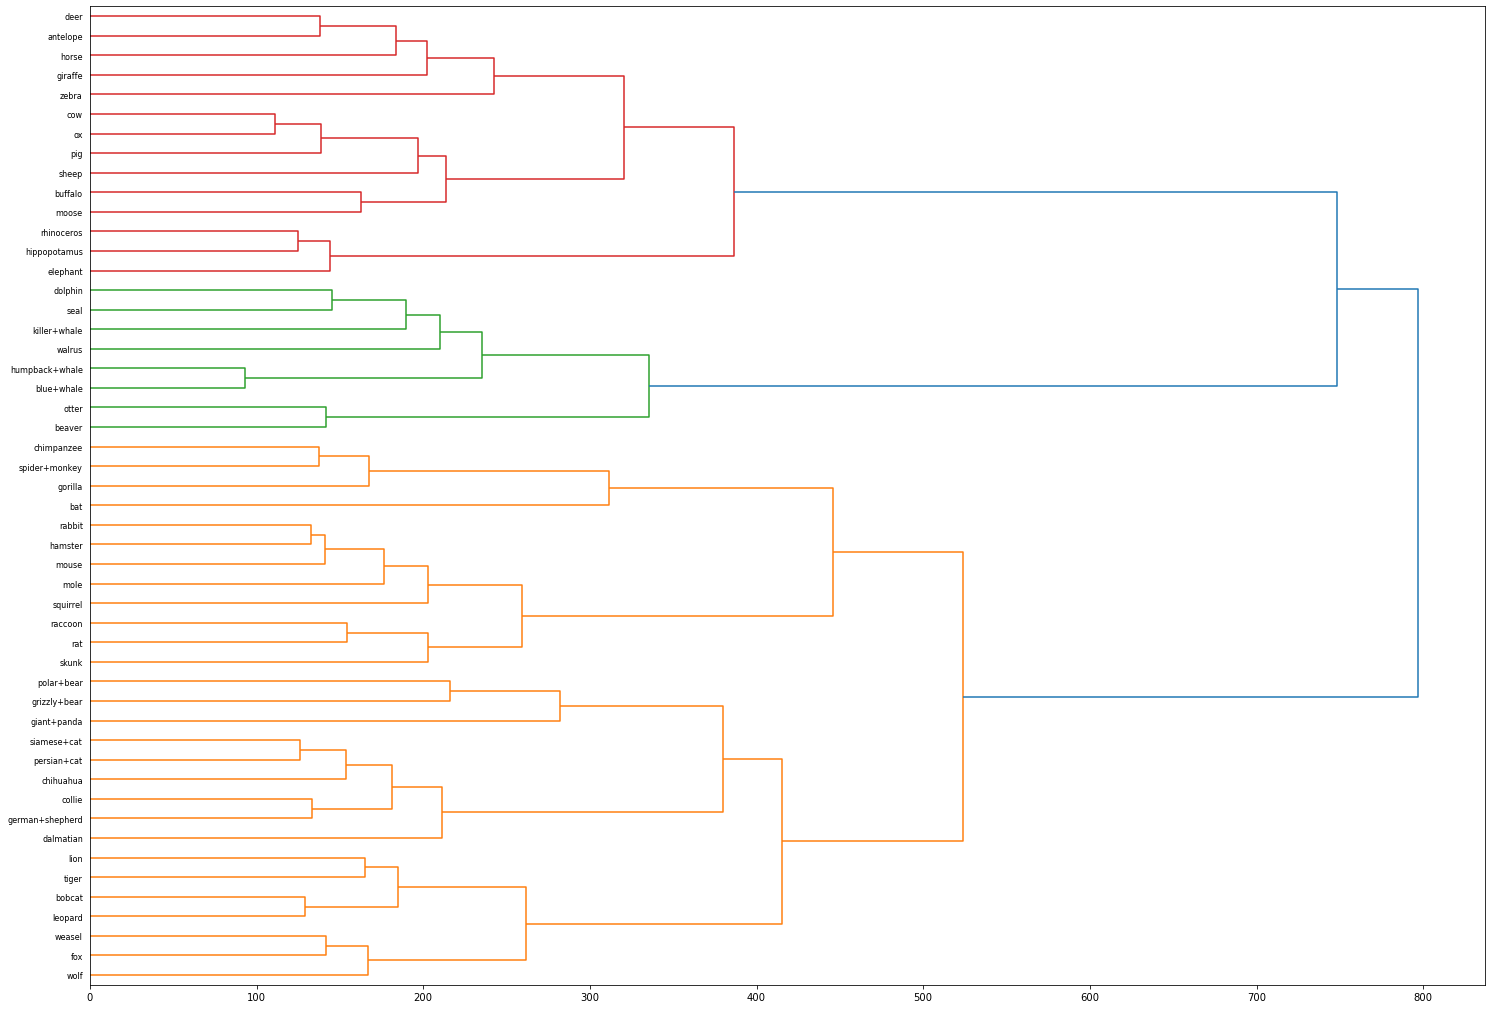

 
      This result makes more sense, from the hierarchy above, it clearly segragated 50 animals 
      into three main groups(herbivores, marine mammals and other mammals), and it splits the 
      mammals other than marine mammals further into two sub-groups(omnivores and carnivore). 
      Also, it makes up the misclassify of 'siamese+cat' and 'persian+cat', which were mistakenly 
      grouped by the K-means classifier in 2(a).


In [50]:
linkage_arr = linkage(X, method='ward')
fig = plt.figure(figsize=(25, 18))
dn = dendrogram(linkage_arr, orientation='right', labels=names)
#plt.rcParams['axes.labelsize'] = 30
print(f"Problem 2(b):")
print(f"===================================================================")
plt.show()
print(""" 
      This result makes more sense, from the hierarchy above, it clearly segragated 50 animals 
      into three main groups(herbivores, marine mammals and other mammals), and it splits the 
      mammals other than marine mammals further into two sub-groups(omnivores and carnivore). 
      Also, it makes up the misclassify of 'siamese+cat' and 'persian+cat', which were mistakenly 
      grouped by the K-means classifier in 2(a).""")